# Cell calling bayesin model and Cellpose segmentation

In [30]:
import pymc3 as pm
import theano.tensor as tt
from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax
from sklearn import preprocessing
import arviz as az

import pickle
import plotnine
from plotnine import *
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.parse import urlparse
from cellpose import models, core
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)
# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
from cellpose import utils
import glob
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io, filters, measure, color, img_as_ubyte

>>> GPU activated? 1


In [2]:
os.chdir(r'F:\HAB_2\PrinzScreen\training_classfication')
from utils import AIPS_cellpose as AC
from utils import AIPS_file_display as AFD

F:\Gil\anaconda\envs\pymc3_cellpose\lib\site-packages\skimage\viewer\utils\__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.


### Load bayes model

In [34]:
path_bayes_model = r'F:\HAB_2\PrinzScreen\training_classfication\models\imbalance'
os.chdir(path_bayes_model)
os.listdir()

['cnn_transfer_learning_Augmentation_drop_layer_4and5.h5',
 'cnn_transfer_learning_Augmentation_drop_layer_4and5_10p.h5',
 'cnn_transfer_learning_Augmentation_drop_layer_4and5_10p_cp.h5',
 'cnn_transfer_learning_Augmentation_drop_layer_4and5_20p.h5',
 'flat_proir.pkl',
 'flat_proir_condansed.pkl',
 'lr.pkl',
 'shrinking_priors.pkl']

In [35]:
with open(os.path.join(path_bayes_model,'shrinking_priors.pkl'), 'rb') as buff:
    data = pickle.load(buff)
model = data['model']
trace = data['trace']

## Cellpose segmentation

In [3]:
path_norm = r'F:\HAB_2\PrinzScreen\training_classfication\raw\mix\selected_images'
os.chdir(path_norm)
images_name = glob.glob("*.tif")

AIPS_pose_object = AC.AIPS_cellpose(Image_name = images_name[1], path= path_norm, model_type="cyto", channels=[0,0])
img = AIPS_pose_object.cellpose_image_load()
# create mask for the entire image
mask, table = AIPS_pose_object.cellpose_segmantation(image_input=img[0,:,:])

In [50]:
table.head()
table_rmv_small = table.loc[table['area'] > 1500,:]

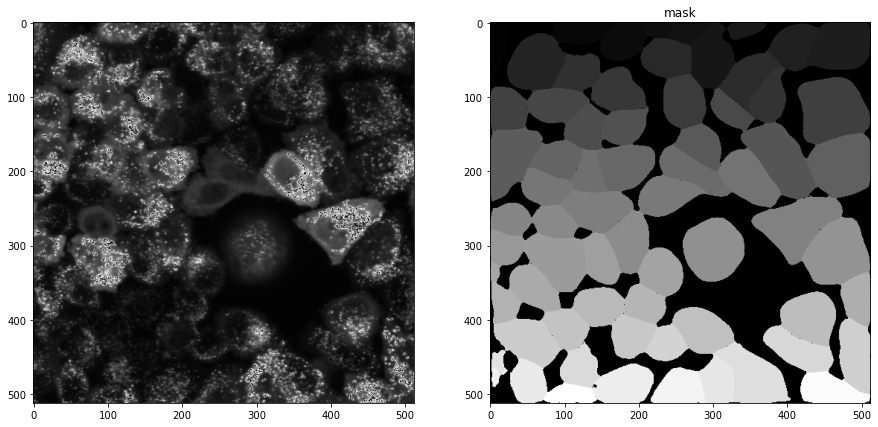

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15)) 
ax[0].imshow(img[0,:,:]*6, cmap=plt.cm.gray) 
ax[0].title.set_text('') 
ax[1].imshow(mask, cmap=plt.cm.gray) 
ax[1].title.set_text('mask') 

In [12]:
table_prop = AIPS_pose_object.measure_properties(img[0,:,:])
table_prop = pd.DataFrame(table_prop)
table_prop.head()

,label,area,eccentricity,euler_number,extent,feret_diameter_max,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,...,moments_normalized-3-2,moments_normalized-3-3,orientation,perimeter,perimeter_crofton,solidity,sd_intensity,skew_intensity,pixelcount,mean_int
0,1,1318,0.932782,1,0.798788,66.610810,40.117146,16.939371,16.939371,299.195984,...,-0.000591,-0.000310,-0.065014,161.254834,155.560686,0.967695,1124.646057,1.172450,1318,2256.179818
1,2,2076,0.921146,1,0.787856,86.683332,441.006824,28.618845,28.618845,69.330354,...,-0.000474,-0.000453,-1.494397,206.468037,198.425491,0.972821,1637.785739,1.798347,2076,3369.328516
2,3,2516,0.652423,1,0.768010,67.424031,236.234733,49.557887,49.557887,181.874097,...,0.000035,-0.000437,-1.036227,192.267027,184.962089,0.970679,1232.420750,1.901008,2516,1425.445151
3,4,797,0.851204,1,0.787549,46.270941,127.962982,-6.791023,-6.791023,35.882999,...,-0.000587,0.000235,1.497573,120.148232,117.178233,0.953349,2068.555386,2.050413,797,3096.097867
4,5,1100,0.873981,1,0.601422,62.625873,186.463187,36.624873,36.624873,55.864327,...,-0.001133,-0.001271,-1.315219,151.053824,145.889522,0.903862,666.495756,1.910266,1100,1536.141818


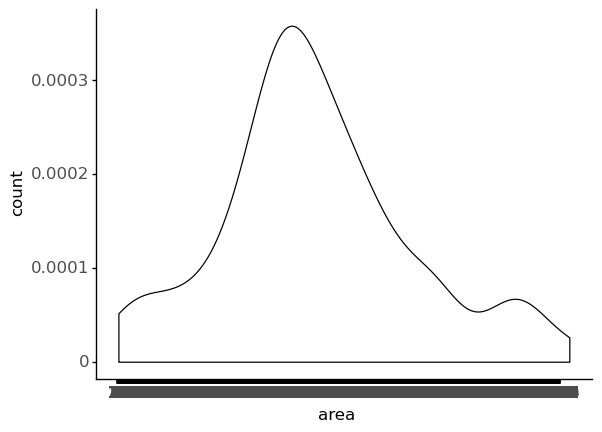

<ggplot: (-9223371870417735352)>

In [24]:
(
    ggplot(table_prop)  # What data to use
  + aes(x="area")  # What variable to use
  + geom_density()  # Geometric object to use for drawing
  + scale_x_continuous(name ="area", breaks = range(0,6500), minor_breaks=np.linspace(1,6000,6,dtype=int).tolist())
  + theme(axis_title_x = element_text(size = 12))
  + theme(axis_title_y = element_text(size = 12))
  + theme(axis_text = element_text(size=12))
  + theme(axis_line = element_line(colour = "black",size=1), panel_border = element_blank(),panel_background = element_blank())
  + labs(title="", x="area", y="count")
)

In [51]:
table_rmv_small_prop = table_prop.loc[table_prop['area'] > 1500,:]

In [36]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()
table_summary_id = table_rmv_small_prop
table_dict={'id':table_summary_id.index.to_list(),
            'Ecc_std':standardize(table_summary_id.eccentricity),
            'ex_std':standardize(table_summary_id.extent),
            'orien_std':standardize(table_summary_id.orientation),
            'solid_std':standardize(table_summary_id.solidity),
            'feret_diameter_max':standardize(np.log(table_summary_id.feret_diameter_max).values),
            'peri_log':standardize(np.log(table_summary_id.perimeter).values),
            'area_log':standardize(np.log(table_summary_id.area).values)}
table_test = pd.DataFrame(table_dict)

In [38]:
RANDOM_SEED = 8927
with model:
    pm.set_data({"Ecc": np.array(table_test.Ecc_std),
                 "ex": np.array(table_test.ex_std),
                 "orien": np.array(table_test.orien_std),
                 "solid": np.array(table_test.solid_std),
                 "peri": np.array(table_test.peri_log),
                 "area": np.array(table_test.area_log)})
    p_post = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

In [39]:
p_test_pred = p_post['class_label'].mean(axis=0)
table_test['predicted'] = p_test_pred

In [41]:
p_test_pred

array([0.612375, 0.6865  , 0.5405  , 0.49375 , 0.643625, 0.527625,
       0.561625, 0.704125, 0.7235  , 0.6565  , 0.554875, 0.56175 ,
       0.36175 , 0.61025 , 0.62325 , 0.65825 , 0.67425 , 0.693   ,
       0.368625, 0.590375, 0.43575 , 0.43175 , 0.66675 , 0.56325 ,
       0.52275 , 0.771875, 0.47375 , 0.599875, 0.582375, 0.47175 ,
       0.47125 , 0.6845  , 0.663   , 0.577   , 0.458125, 0.428625,
       0.708   , 0.4615  , 0.624   , 0.599375, 0.573875, 0.594875,
       0.72225 , 0.634625, 0.588625, 0.46925 , 0.5145  , 0.6285  ,
       0.672875, 0.482   , 0.450625, 0.75725 , 0.529625, 0.698375,
       0.486375, 0.671   , 0.671375, 0.54725 , 0.623   , 0.504875])

In [40]:
print(len(table_test))
print(len(table_rmv_small))

60
60


In [52]:
predict = np.where(p_test_pred > 0.5, 1, 0)
table_rmv_small['predict'] = predict
table_rmv_small.head()

,area,centroid-0,centroid-1,predict
label,,,,
2,2076,13.196532,121.621869,1
3,2516,25.619237,178.550477,1
6,3811,47.063500,297.319076,1
8,4609,31.920373,471.451725,0
9,2936,31.909401,408.066076,1


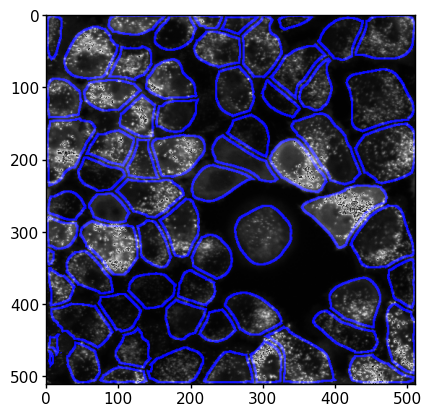

In [44]:
compsite_object = AFD.Compsite_display(input_image=img[0,:,:]*5,mask_roi=mask)
comp_img = compsite_object.draw_ROI_contour()
plt.imshow(comp_img)

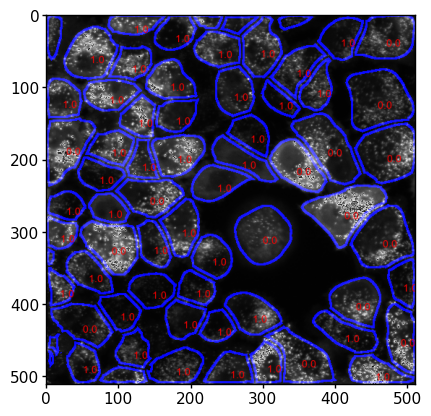

In [53]:
table_pred, impil = AIPS_pose_object.display_image_prediction(img = comp_img ,prediction_table = table_rmv_small,
                                                              font_select = None, font_size = 14, windows=True,  lable_draw = 'predict',round_n = 3)
plt.imshow(impil)

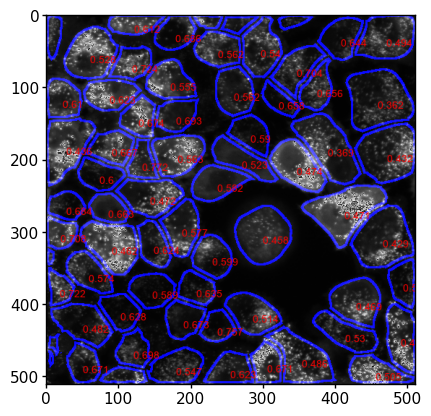

In [56]:
table_rmv_small_predict_raw = table_rmv_small
table_rmv_small_predict_raw = table_rmv_small.assign(predict = np.round(p_test_pred,3))
table_pred, impil = AIPS_pose_object.display_image_prediction(img = comp_img ,prediction_table = table_rmv_small_predict_raw,
                                                              font_select = None, font_size = 14, windows=True,  lable_draw = 'predict',round_n = 3)
plt.imshow(impil)

In [55]:
table_rmv_small_predict_raw.head()

,area,centroid-0,centroid-1,predict
label,,,,
2,2076,13.196532,121.621869,1
3,2516,25.619237,178.550477,1
6,3811,47.063500,297.319076,1
8,4609,31.920373,471.451725,0
9,2936,31.909401,408.066076,1
